In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
df = pd.read_csv("data/emotions-dataset.csv")
df

,message,emotion
0,i used to be able to hang around talk with the...,anger
1,i get made to feel left out and unimportant in...,sadness
2,i wasnt going to post today as i am feeling qu...,sadness
3,i feel extremely delicate and a bit helpless,love
4,i feel frightened that i might fail to notice ...,fear
...,...,...
11995,i feel useless for wasting k hours k just for ...,sadness
11996,i feel rushed and pulled and rung out and i kn...,anger
11997,i feel absolutely disgusted,anger
11998,i know that we are all sinners and fall short ...,sadness


Check if the dataset is balanced.

<Axes: xlabel='emotion'>

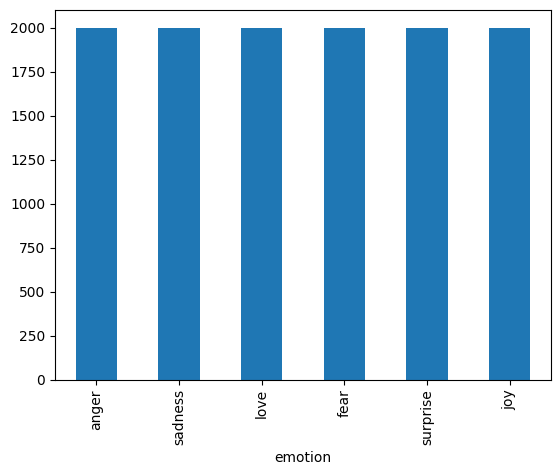

In [3]:
df["emotion"].value_counts().plot.bar()

Check if there are missing values.

In [4]:
df.isnull().sum()

,0
message,0
emotion,0


Plot the distribution of words per text.

<Axes: ylabel='Frequency'>

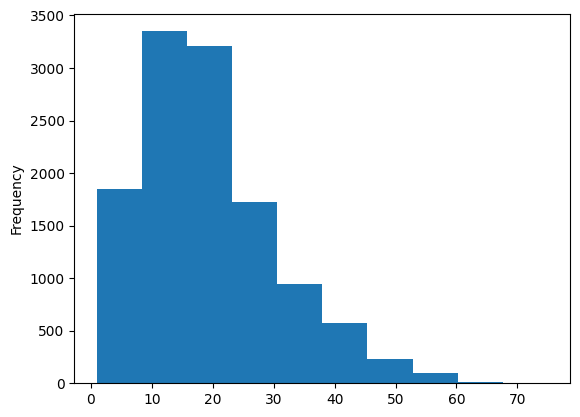

In [5]:
df["message"].str.split(" ").apply(len).plot.hist()

<Axes: >

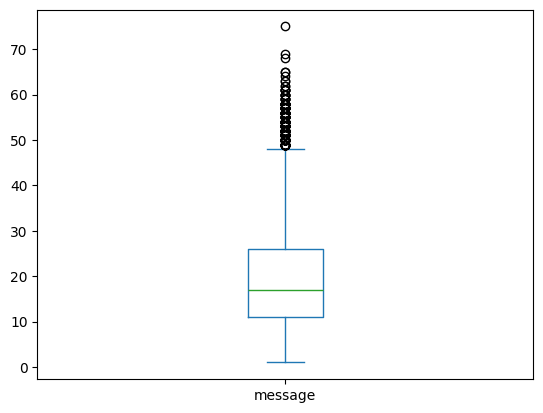

In [6]:
df["message"].str.split().apply(len).plot.box()

In [7]:
df = df[df["message"].str.split().apply(len) < 45].copy(deep=True)
df

,message,emotion
0,i used to be able to hang around talk with the...,anger
1,i get made to feel left out and unimportant in...,sadness
3,i feel extremely delicate and a bit helpless,love
4,i feel frightened that i might fail to notice ...,fear
5,i feel stubborn because i just want my seattle...,anger
...,...,...
11995,i feel useless for wasting k hours k just for ...,sadness
11996,i feel rushed and pulled and rung out and i kn...,anger
11997,i feel absolutely disgusted,anger
11998,i know that we are all sinners and fall short ...,sadness


<Axes: ylabel='Frequency'>

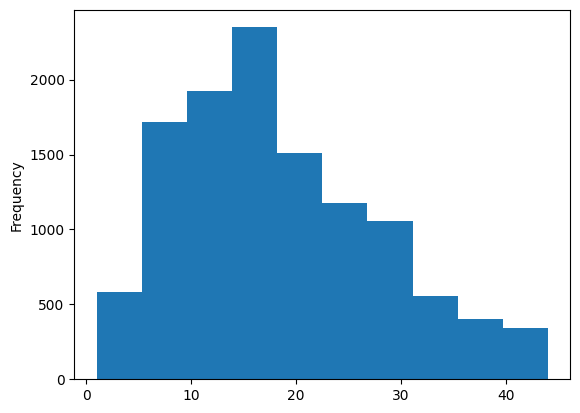

In [8]:
df["message"].str.split().apply(len).plot.hist()

<Axes: >

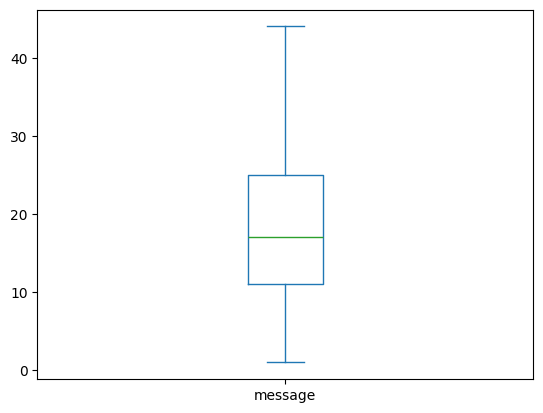

In [9]:
df["message"].str.split().apply(len).plot.box()

In [10]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [11]:
vocabulary = get_vocabulary(df["message"].tolist())

In [12]:
len(vocabulary)

12665

In [13]:
max_vocabulary_size = 10000

In [14]:
X, y = df["message"], pd.get_dummies(df["emotion"])

In [15]:
y.head()

,anger,fear,joy,love,sadness,surprise
0,True,False,False,False,False,False
1,False,False,False,False,True,False
3,False,False,False,True,False,False
4,False,True,False,False,False,False
5,True,False,False,False,False,False


In [16]:
num_classes = y.shape[1]
num_classes

6

In [17]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [18]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

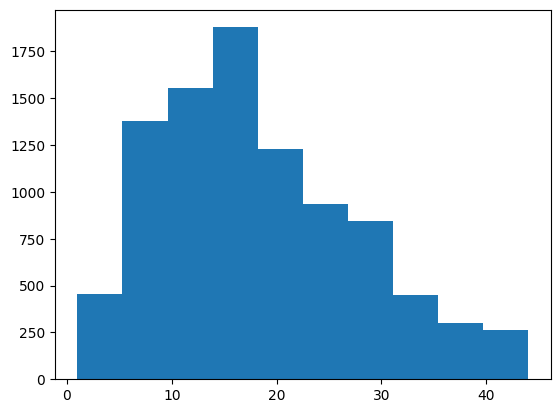

In [19]:
plt.hist([len(tokens) for tokens in train_X]);

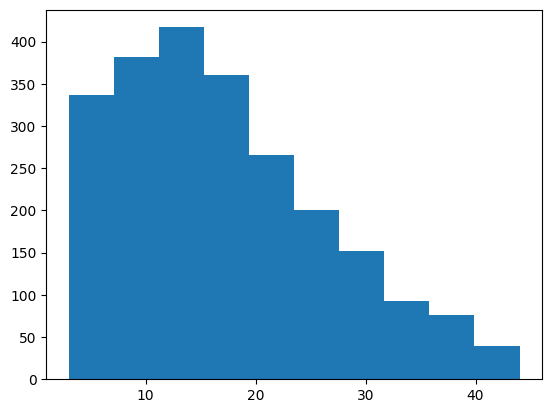

In [20]:
plt.hist([len(tokens) for tokens in test_X]);

In [21]:
maxlen = 32

In [22]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [23]:
train_X.shape, test_X.shape

((9285, 32), (2322, 32))

In [24]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=128),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="softmax")
])

In [25]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [26]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=3)

Epoch 1/3
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - f1_score: 0.1365 - loss: 1.7704 - precision: 0.2891 - recall: 0.0076 - val_f1_score: 0.4330 - val_loss: 1.3210 - val_precision: 0.8689 - val_recall: 0.1142
Epoch 2/3
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - f1_score: 0.5317 - loss: 1.0687 - precision: 0.7750 - recall: 0.3045 - val_f1_score: 0.7599 - val_loss: 0.7195 - val_precision: 0.7964 - val_recall: 0.7351
Epoch 3/3
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - f1_score: 0.8221 - loss: 0.5578 - precision: 0.8377 - recall: 0.8024 - val_f1_score: 0.8121 - val_loss: 0.6118 - val_precision: 0.8264 - val_recall: 0.8078


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 32, 32)              │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 16, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 16, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,359,860 (16.63 MB)

 Trainable params: 1,453,286 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,906,574 (11.09 MB)

<Axes: >

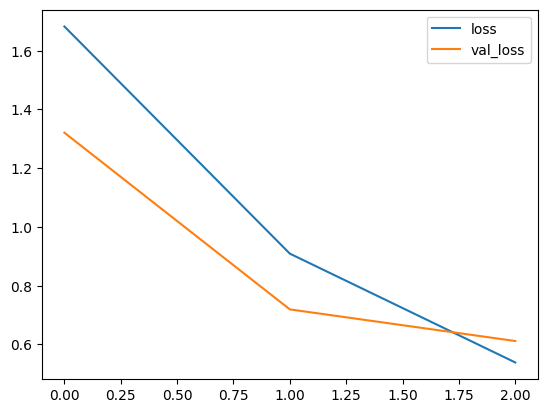

In [28]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [29]:
preds = model.predict(test_X)

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [30]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [31]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       373
           1       0.82      0.65      0.73       400
           2       0.66      0.74      0.70       373
           3       0.88      0.97      0.92       390
           4       0.84      0.82      0.83       387
           5       0.84      0.96      0.90       399

    accuracy                           0.82      2322
   macro avg       0.83      0.82      0.82      2322
weighted avg       0.83      0.82      0.82      2322



Text(0.5, 1.0, 'Confusion Matrix')

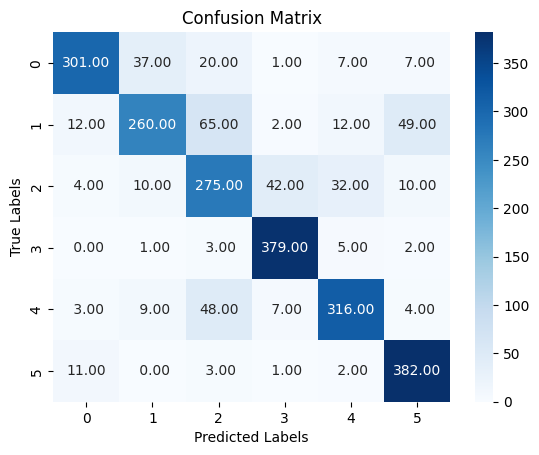

In [32]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [33]:
y.columns

Index(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='object')